# w261 Final Project - Clickthrough Rate Prediction


[Your team number (from the spreadsheet)]   
[Your team names]   
Summer 2019, section [Your section numbers>]   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

Today, online advertising is a billion dollars industry. In the US alone, more than 100 billion dollars was spent on online advertising. In the last decade, online advertising has also evolved from a primitive impression campaign, or pay per impression, to pay per click model. In this Pay-per-click policy, an advertiser has to pay for only those ads which have some clicks on them. Therefore it is essential for companies such as Google, Facebook, and many advertisement agencies need to improve and optimize their click-through rate (CTR). In this new model, advertisement agencies goal is not only limited to avoid irrelevant and false impressions, but also to present the user with the Ad that is believed to have the highest click propensity. 

In this project, we're presented with a CTR dataset from Criteo. Criteo is sharing week's worth of data, over 45M records of traffic logs, to develop models predicting ad click-through rate (CTR). Criteo is a personalized retargeting company that works with Internet retailers to serve personalized online display advertisements to consumers who have previously visited the advertiser's website. 

In this project, the team will present a machine learning framework based on logistic regression that is specifically designed to tackle the specifics of this problem. We will use Criteo training data set to build a logistic regression model that can tell us the probability of a user clicking on a given ad. We will also be able to identify the list of features that have the highest impact in influencing the click decision. 

# __Section 2__ - Algorithm Explanation

### LogisticRegression, RandomForest and GradientBoosting

# __Section 3__ - EDA & Challenges

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import when  
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [5]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [10]:
#Load the data

df = spark.read.csv('data/dac/train.small.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- _1: integer (nullable = true)
 |-- _2: integer (nullable = true)
 |-- _3: integer (nullable = true)
 |-- _4: integer (nullable = true)
 |-- _5: integer (nullable = true)
 |-- _6: integer (nullable = true)
 |-- _7: integer (nullable = true)
 |-- _8: integer (nullable = true)
 |-- _9: integer (nullable = true)
 |-- _10: integer (nullable = true)
 |-- _11: integer (nullable = true)
 |-- _12: integer (nullable = true)
 |-- _13: integer (nullable = true)
 |-- _14: integer (nullable = true)
 |-- _15: string (nullable = true)
 |-- _16: string (nullable = true)
 |-- _17: string (nullable = true)
 |-- _18: string (nullable = true)
 |-- _19: string (nullable = true)
 |-- _20: string (nullable = true)
 |-- _21: string (nullable = true)
 |-- _22: string (nullable = true)
 |-- _23: string (nullable = true)
 |-- _24: string (nullable = true)
 |-- _25: string (nullable = true)
 |-- _26: string (nullable = true)
 |-- _27: string (nullable = true)
 |-- _28: string (nullable = true)
 |-- _29: 

In [11]:
#Store the original columns
cols = df.columns

In [12]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
_1,0,0,1,0,0
_2,0,0,NaN,NaN,4
_3,0,8,1,-1,64
_4,2,NaN,3,NaN,4
_5,9,NaN,20,NaN,2
_6,1366,4910,17647,311637,1490
_7,316,NaN,30,NaN,50
_8,24,NaN,1,0,6
_9,47,8,1,0,12
_10,350,NaN,30,1,27


In [16]:
#Get numeric and categorical column names
numericCols = df.columns[1:14]
categoricalColumns = df.columns[16:41]

print(numericCols)
print(categoricalColumns)

['_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14']
['_17', '_18', '_19', '_20', '_21', '_22', '_23', '_24', '_25', '_26', '_27', '_28', '_29', '_30', '_31', '_32', '_33', '_34', '_35', '_36', '_37', '_38', '_39', '_40']


In [17]:
#Data distribution

df.describe().select('Summary', '_2', '_3', '_4', '_5', '_6').show()

+-------+------------------+----------------+-----------------+-----------------+-----------------+
|Summary|                _2|              _3|               _4|               _5|               _6|
+-------+------------------+----------------+-----------------+-----------------+-----------------+
|  count|              2764|            5000|             4014|             4012|             4859|
|   mean|3.0861070911722144|        111.8884|20.57498754359741|7.587487537387837|19752.57089936201|
| stddev| 7.437360728411959|398.904083256824|58.24237003906267|8.949486932145078|74237.14669289338|
|    min|                 0|              -2|                0|                0|                0|
|    max|               151|            5945|             2050|               91|          1577121|
+-------+------------------+----------------+-----------------+-----------------+-----------------+



In [18]:
df.describe().select('Summary', '_7', '_8', '_9', '_10', '_11').show()

+-------+------------------+------------------+------------------+------------------+------------------+
|Summary|                _7|                _8|                _9|               _10|               _11|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              3800|              4778|              4999|              4778|              2764|
|   mean|124.05131578947369|15.510464629552114|12.320464092818563|103.23231477605692| 0.532561505065123|
| stddev| 347.0117403373191|48.293716133203866|13.536432961145458|210.93376545285946|0.6234846166130683|
|    min|                 0|                 0|                 0|                 0|                 0|
|    max|              5936|              1036|               237|              4144|                 5|
+-------+------------------+------------------+------------------+------------------+------------------+



In [19]:
df.describe().select('Summary', '_12', '_13', '_14').show()

+-------+-----------------+------------------+------------------+
|Summary|              _12|               _13|               _14|
+-------+-----------------+------------------+------------------+
|  count|             4778|              1152|              4012|
|   mean|2.620971117622436|0.8732638888888888| 8.593469591226322|
| stddev|5.097635360270372|3.5293847192911856|11.277355438010085|
|    min|                0|                 0|                 0|
|    max|               81|                43|               182|
+-------+-----------------+------------------+------------------+



In [20]:
#Fill missing values - numerical

df = df.na.fill(0)

#for col in numericCols:
#    df= df.withColumn(col, when(df[col]>0,1).otherwise(0))


#imputer = Imputer(inputCols = numericCols, outputCols = numericCols)
#imp_model = imputer.fit(df)

#df = imp_model.transform(df)
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
_1,0,0,1,0,0
_2,0,0,0,0,4
_3,0,8,1,-1,64
_4,2,0,3,0,4
_5,9,0,20,0,2
_6,1366,4910,17647,311637,1490
_7,316,0,30,0,50
_8,24,0,1,0,6
_9,47,8,1,0,12
_10,350,0,30,1,27


In [21]:
print(df[df['_1'] == 0].count())
print(df[df['_1'] == 1].count())

3729
1271


In [58]:
#df.fillna(df.mean())

#df['_c1'].fillna((df['_c1'].mean()), inplace=True)

In [22]:
stages = []
indexerCols = []

for categoricalCol in categoricalColumns:
    indexerCol = categoricalCol + "Index"
    indexer = StringIndexer(inputCol=categoricalCol, outputCol= indexerCol).setHandleInvalid("keep")
    stages += [indexer]
    indexerCols.append(indexerCol)

label_stringIdx = StringIndexer(inputCol = '_1', outputCol = 'output')
stages += [label_stringIdx]

In [23]:
assembler = VectorAssembler(inputCols=indexerCols + numericCols, outputCol="features")
stages += [assembler]

In [24]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

selectedCols = ['output', 'features'] + cols
df = df.select(selectedCols)

pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
output,0,0,1,0,0
features,"[156.0, 220.0, 0.0, 0.0, 31.0, 4.0, 0.0, 1.0, ...","(1316.0, 1446.0, 0.0, 5.0, 462.0, 3.0, 0.0, 77...","[1452.0, 86.0, 0.0, 1.0, 970.0, 0.0, 0.0, 18.0...","[598.0, 2133.0, 0.0, 1.0, 174.0, 1.0, 1.0, 560...","[58.0, 69.0, 0.0, 1.0, 313.0, 2.0, 0.0, 1176.0..."
_1,0,0,1,0,0
_2,0,0,0,0,4
_3,0,8,1,-1,64
_4,2,0,3,0,4
_5,9,0,20,0,2
_6,1366,4910,17647,311637,1490
_7,316,0,30,0,50
_8,24,0,1,0,6


In [25]:
standardscaler=StandardScaler().setInputCol("features").setOutputCol("scaled_features")
df=standardscaler.fit(df).transform(df)
df.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[156.0,220.0,0.0,...|[0.14742378229343...|
|(37,[0,1,3,4,5,7,...|(37,[0,1,3,4,5,7,...|
|[1452.0,86.0,0.0,...|[1.37217520442350...|
|[598.0,2133.0,0.0...|[0.56512449879149...|
|[58.0,69.0,0.0,1....|[0.05481140623730...|
+--------------------+--------------------+
only showing top 5 rows



In [26]:
#Train test split

train, test = df.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3476
Test Dataset Count: 1524


In [27]:
#Imbalance check

dataset_size=float(train.select("output").count())
numPositives=train.select("output").where('output == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 897
Percentage of ones are 25.805523590333717


In [28]:
#Rebalance data

BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7419447640966629


In [29]:
train=train.withColumn("classWeights", when(train.output == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.2580552359033371|
|0.2580552359033371|
|0.2580552359033371|
|0.2580552359033371|
|0.2580552359033371|
+------------------+
only showing top 5 rows



In [30]:
#Feature selection

css = ChiSqSelector(featuresCol='scaled_features',outputCol='Aspect',labelCol='output',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# __Section 4__ - Algorithm Implementation

### Logistic Regression

In [31]:
lr = LogisticRegression(maxIter=10, featuresCol="Aspect", labelCol="output", 
                        weightCol="classWeights", predictionCol="prediction")

# Fit the model
lrModel = lr.fit(train)

predict_train=lrModel.transform(train)
predict_test=lrModel.transform(test)

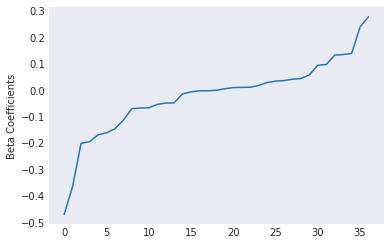

In [32]:
#Evaluate the model

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

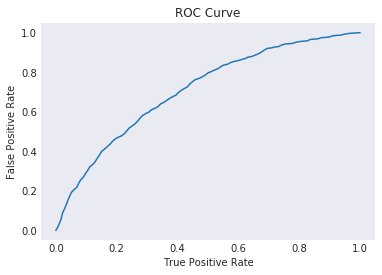

Training set areaUnderROC: 0.7089066869315366


In [33]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

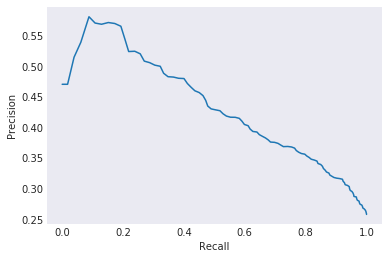

In [34]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [35]:
predict_test.select("output","prediction").show(10)

+------+----------+
|output|prediction|
+------+----------+
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       1.0|
|   0.0|       1.0|
|   0.0|       0.0|
+------+----------+
only showing top 10 rows



In [36]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'output')

predict_test.select("output","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+------+--------------------+----------+--------------------+
|output|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|   0.0|[1.59825477056568...|       0.0|[0.83177432389147...|
|   0.0|[1.77137133510478...|       0.0|[0.85462812708473...|
|   0.0|[1.01209724544785...|       0.0|[0.73343038291792...|
|   0.0|[0.61877786124526...|       0.0|[0.64994054119031...|
|   0.0|[1.49888068393454...|       0.0|[0.81740747482782...|
+------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.7089600724140556
The area under ROC for test set is 0.6908602650546408


In [37]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.aggregationDepth,[2,10])\
    .addGrid(lr.elasticNetParam,[0.0, 0.5])\
    .addGrid(lr.maxIter,[10, 100])\
    .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
    .build()

In [38]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train=cvModel.transform(train)
predict_test=cvModel.transform(test)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))


The area under ROC for train set after CV  is 0.7101656765496804
The area under ROC for test set after CV  is 0.6967054173448046


### RF

In [39]:
rf = RandomForestClassifier(numTrees=10, featuresCol="scaled_features", labelCol="output", predictionCol="prediction")
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('output', 'prediction', 'probability').show(10)

+------+----------+--------------------+
|output|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.89626505355320...|
|   0.0|       0.0|[0.81357055383976...|
|   0.0|       0.0|[0.84311810087923...|
|   0.0|       0.0|[0.91826636038525...|
|   0.0|       0.0|[0.87025017169424...|
|   0.0|       0.0|[0.84122245384141...|
|   0.0|       0.0|[0.87014906502321...|
|   0.0|       0.0|[0.82394277152281...|
|   0.0|       0.0|[0.78971074255703...|
|   0.0|       0.0|[0.86856176370029...|
+------+----------+--------------------+
only showing top 10 rows



In [40]:
evaluator = BinaryClassificationEvaluator(labelCol = 'output')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7191095094164167


### GB

In [41]:
gbt = GBTClassifier(maxIter=10, featuresCol="scaled_features", labelCol="output", predictionCol="prediction")
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('output', 'prediction', 'probability').show(10)

+------+----------+--------------------+
|output|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.89252497075372...|
|   0.0|       0.0|[0.87260540739507...|
|   0.0|       0.0|[0.84714575605966...|
|   0.0|       0.0|[0.84446317273783...|
|   0.0|       0.0|[0.86781508884201...|
|   0.0|       0.0|[0.88923217417265...|
|   0.0|       0.0|[0.89498695775133...|
|   0.0|       0.0|[0.69212321448474...|
|   0.0|       0.0|[0.80963865721781...|
|   0.0|       0.0|[0.79771702269654...|
+------+----------+--------------------+
only showing top 10 rows



In [42]:
evaluator = BinaryClassificationEvaluator(labelCol = 'output')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7142571495001185


In [125]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: scaled_features)
labelCol: label column name. (default: label, current: output)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)


# __Section 5__ - Course Concepts